In [2]:
### Library Imports

import pandas as pd
import numpy as np
import math 
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf 
from datetime import timedelta
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
### Import the Stock Info

ticker = 'GOOG'
start_date = '2018-1-1'

data = yf.Ticker(ticker)
# Fetch historical data starting from the specified start_date
history = data.history(start = start_date)
df = pd.DataFrame(history)
# Reset index to make headings in the same row
df.reset_index(inplace = True)
# Convert the date column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])
# Extract only the date part
df['Date'] = df['Date'].dt.date
# Drop 'Dividends' and 'Stock Splits' columns
#df.drop(['Dividends', 'Stock Splits'], axis = 1)

#date = df['Date']

df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02,52.417000,53.347000,52.261501,53.250000,24752000,0.0,0.0
1,2018-01-03,53.215500,54.314499,53.160500,54.124001,28604000,0.0,0.0
2,2018-01-04,54.400002,54.678501,54.200100,54.320000,20092000,0.0,0.0
3,2018-01-05,54.700001,55.212502,54.599998,55.111500,25582000,0.0,0.0
4,2018-01-08,55.111500,55.563499,55.081001,55.347000,20952000,0.0,0.0


In [4]:
### Autoregression Model

## Split the data into train and test 
n = len(df)
n_train = int(0.8 * n) # Set the train data set to 80% of the total df
n_test = n - n_train
# Create train and test dataframes
train_df, test_df = df[:n_train], df[n_train:]

## Train the autoregression model (using already trained and tested split dataframes)
model = AutoReg(train_df['Close'], lags=5)
model_fit = model.fit()

## Make predictions
predictions = model_fit.predict(start=len(train_df), end=(len(train_df) + len(test_df) - 1), dynamic=False)
forecast_period = len(test_df)
forecast_dates = pd.date_range(start=test_df['Date'].iloc[0], periods=forecast_period, freq='B')  # Exclude the first date

## Combine forecasted dates with the predicted values
prediction_df = pd.DataFrame({'Date': forecast_dates, 'Predicted': predictions})
prediction_df

,Date,Predicted
1263,2023-01-09,88.143884
1264,2023-01-10,88.276564
1265,2023-01-11,88.257497
1266,2023-01-12,88.260107
1267,2023-01-13,88.279484
...,...,...
1574,2024-03-19,93.779838
1575,2024-03-20,93.793704
1576,2024-03-21,93.807548
1577,2024-03-22,93.821369


In [7]:
### Merge Predicted with Actual

# Convert 'Date' column to datetime64[ns] in prediction_df
prediction_df['Date'] = pd.to_datetime(prediction_df['Date'])

# Convert 'Date' column to datetime64[ns] in test_df
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Merge prediction_df with test_df on the 'Date' column
result_df = pd.merge(prediction_df, test_df[['Date', 'Close']], on='Date', how='left')
result_df.rename(columns={'Close': 'Actual'}, inplace=True)  # Rename the 'Close' column to 'Actual'

# Print the result_df DataFrame
print(result_df)


          Date  Predicted      Actual
0   2023-01-09  88.143884   88.800003
1   2023-01-10  88.276564   89.239998
2   2023-01-11  88.257497   92.260002
3   2023-01-12  88.260107   91.910004
4   2023-01-13  88.279484   92.800003
..         ...        ...         ...
311 2024-03-19  93.779838  147.919998
312 2024-03-20  93.793704  149.679993
313 2024-03-21  93.807548  148.740005
314 2024-03-22  93.821369  151.770004
315 2024-03-25  93.835169  151.149994

[316 rows x 3 columns]


/var/folders/n5/bknqp6qs37l5l4bwv9wv3bs40000gn/T/ipykernel_19696/1392009707.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Date'] = pd.to_datetime(test_df['Date'])


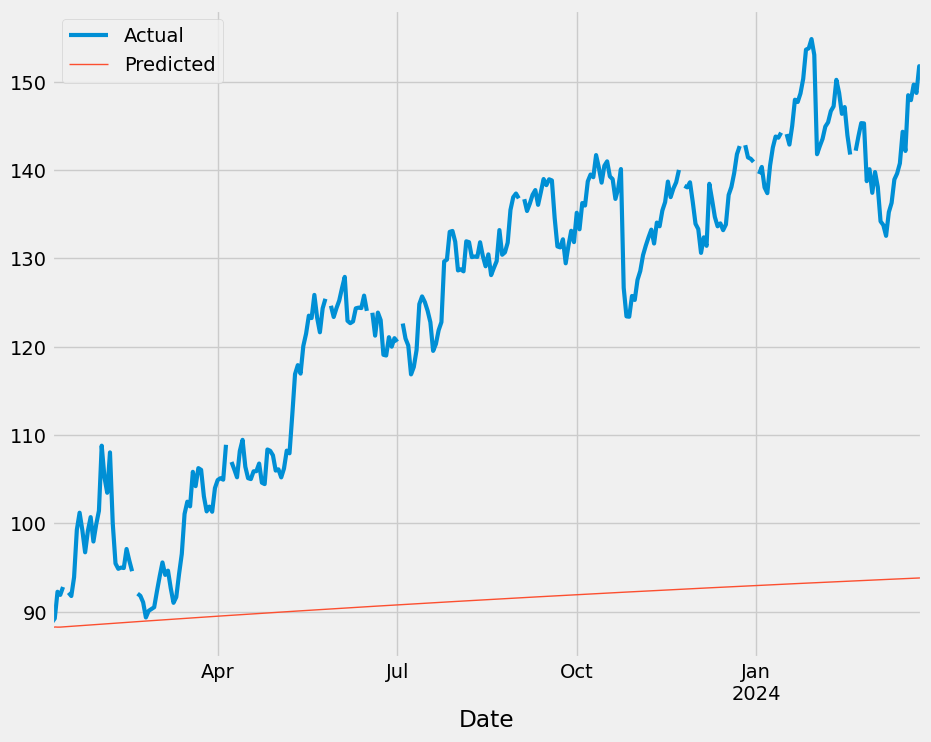

In [8]:
### Plotting Function

# Plot both actual and predicted data on the same graph
ax = result_df.plot(x = 'Date', y = 'Actual', figsize = (10, 8), linewidth = 3)
result_df.plot(x = 'Date', y = 'Predicted', ax = ax, linewidth = 1)
plt.show()